In [4]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "seaborn"

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

import sys
sys.path.append("..")
from pygalaxy import Euler_symplectic_tree, ADB6
from pygalaxy import init_solar_system
from pygalaxy.barnes_hut_array import compute_energy_and_tree_structure
#from pygalaxy.naive import compute_energy

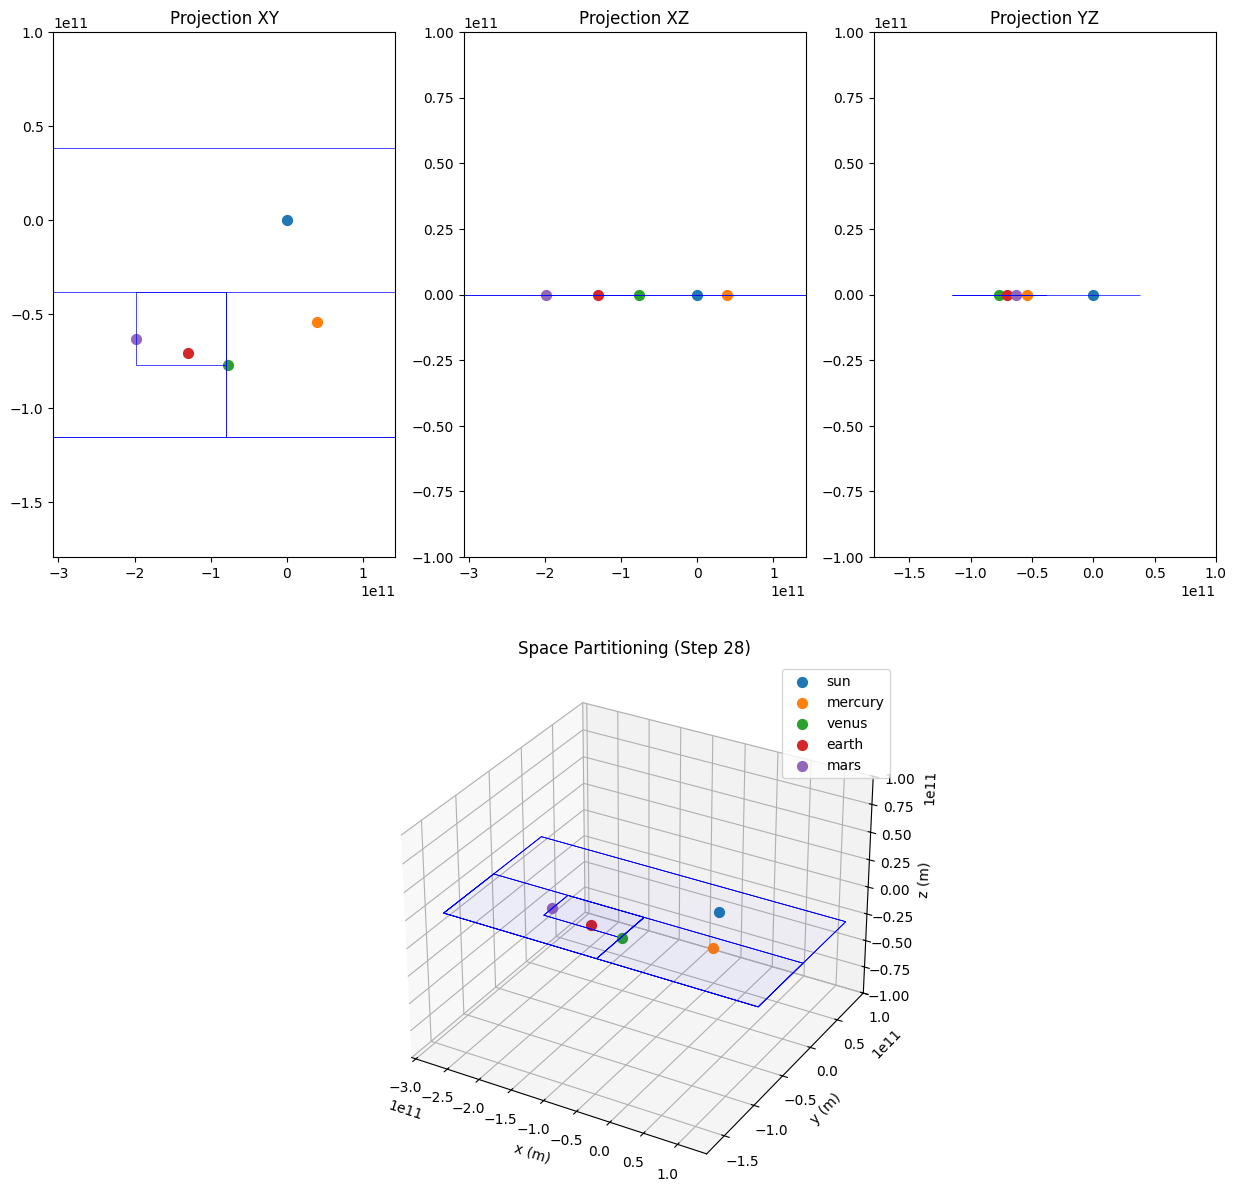

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Rectangle

# Simulation parameters
dt = 86400  # 1 day in seconds
nt = 30  # Number of time steps
dim = 3  # Number of dimensions

# Initialize solar system
mass, particles, planets = init_solar_system(dim)

# Number of bodies
nbodies = particles.shape[0]

# Initialize the integrator
time_method = Euler_symplectic_tree(dt, nbodies, dim, compute_energy_and_tree_structure)  # Replace `None` with the appropriate force computation method

# Arrays to store positions and velocities over time
coords = np.zeros((nt, nbodies, dim))
coords[0] = particles[:, :, 0]  # Initial positions

velocities = np.zeros((nt, nbodies, dim))
velocities[0] = particles[:, :, 1]  # Initial velocities

trees = []

# Time-stepping loop
for i in range(nt - 1):
    time_method.update(mass, particles)
    coords[i + 1] = particles[:, :, 0]
    velocities[i + 1] = particles[:, :, 1]
    trees.append(time_method.tree)  # Stocke la structure de l'arbre à chaque étape

# Fonction pour mettre à jour l'animation
def update(frame):
    for ax in [ax1, ax2, ax3, ax4]:
        ax.clear()

    # Récupération de l'arbre pour la frame actuelle
    tree = trees[frame]

    # Vérification de l'arbre
    if "cell_centers" not in tree or "cell_radii" not in tree:
        print(f"Frame {frame}: Tree structure missing keys.")
        return  # Si l'arbre est vide ou mal formaté, ignorer

    # Projection XY
    ax1.set_title("Projection XY")
    ax1.set_xlim(np.min(coords[:, :, 0]) - 1e11, np.max(coords[:, :, 0]) + 1e11)
    ax1.set_ylim(np.min(coords[:, :, 1]) - 1e11, np.max(coords[:, :, 1]) + 1e11)
    for i in range(len(planets)):
        ax1.scatter(coords[frame, i, 0], coords[frame, i, 1], label=planets[i], s=50)

    # Dessin des boîtes dans XY
    for i in range(tree["cell_centers"].shape[0]):
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]
        if len(center) != 3 or len(radius) != 3:
            print(f"Invalid cell data at index {i}: center={center}, radius={radius}")
            continue
        rect = Rectangle(
            (center[0] - radius[0], center[1] - radius[1]),
            2 * radius[0],
            2 * radius[1],
            edgecolor="blue",
            facecolor="none",
            linewidth=0.5
        )
        ax1.add_patch(rect)
    """

    # Projection XZ
    ax2.set_title("Projection XZ")
    ax2.set_xlim(np.min(coords[:, :, 0]) - 1e11, np.max(coords[:, :, 0]) + 1e11)
    ax2.set_ylim(np.min(coords[:, :, 2]) - 1e11, np.max(coords[:, :, 2]) + 1e11)
    for i in range(len(planets)):
        ax2.scatter(coords[frame, i, 0], coords[frame, i, 2], label=planets[i], s=50)

    # Dessin des boîtes dans XZ
    for i in range(tree["cell_centers"].shape[0]):
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]
        if len(center) != 3 or len(radius) != 3:
            continue
        rect = Rectangle(
            (center[0] - radius[0], center[2] - radius[2]),
            2 * radius[0],
            2 * radius[2],
            edgecolor="blue",
            facecolor="none",
            linewidth=0.5
        )
        ax2.add_patch(rect)

    # Projection YZ
    ax3.set_title("Projection YZ")
    ax3.set_xlim(np.min(coords[:, :, 1]) - 1e11, np.max(coords[:, :, 1]) + 1e11)
    ax3.set_ylim(np.min(coords[:, :, 2]) - 1e11, np.max(coords[:, :, 2]) + 1e11)
    for i in range(len(planets)):
        ax3.scatter(coords[frame, i, 1], coords[frame, i, 2], label=planets[i], s=50)

    # Dessin des boîtes dans YZ
    for i in range(tree["cell_centers"].shape[0]):
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]
        if len(center) != 3 or len(radius) != 3:
            continue
        rect = Rectangle(
            (center[1] - radius[1], center[2] - radius[2]),
            2 * radius[1],
            2 * radius[2],
            edgecolor="blue",
            facecolor="none",
            linewidth=0.5
        )
        ax3.add_patch(rect)

    # Vue 3D classique
    ax4.set_title(f"Space Partitioning (Step {frame})")
    ax4.set_xlim(np.min(coords[:, :, 0]) - 1e11, np.max(coords[:, :, 0]) + 1e11)
    ax4.set_ylim(np.min(coords[:, :, 1]) - 1e11, np.max(coords[:, :, 1]) + 1e11)
    ax4.set_zlim(np.min(coords[:, :, 2]) - 1e11, np.max(coords[:, :, 2]) + 1e11)
    ax4.set_xlabel("x (m)")
    ax4.set_ylabel("y (m)")
    ax4.set_zlabel("z (m)")
    for i in range(len(planets)):
        ax4.scatter(coords[frame, i, 0], coords[frame, i, 1], coords[frame, i, 2], label=planets[i], s=50)

    # Dessin des boîtes dans la vue 3D
    for i in range(tree["cell_centers"].shape[0]):
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]
        if len(center) != 3 or len(radius) != 3:
            continue
        # Coordonnées des sommets de la boîte
        vertices = [
            [center[0] - radius[0], center[1] - radius[1], center[2] - radius[2]],
            [center[0] + radius[0], center[1] - radius[1], center[2] - radius[2]],
            [center[0] + radius[0], center[1] + radius[1], center[2] - radius[2]],
            [center[0] - radius[0], center[1] + radius[1], center[2] - radius[2]],
            [center[0] - radius[0], center[1] - radius[1], center[2] + radius[2]],
            [center[0] + radius[0], center[1] - radius[1], center[2] + radius[2]],
            [center[0] + radius[0], center[1] + radius[1], center[2] + radius[2]],
            [center[0] - radius[0], center[1] + radius[1], center[2] + radius[2]],
        ]

        # Faces de la boîte
        faces = [
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[1], vertices[2], vertices[6], vertices[5]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[3], vertices[0], vertices[4], vertices[7]],
            [vertices[0], vertices[1], vertices[2], vertices[3]],
            [vertices[4], vertices[5], vertices[6], vertices[7]],
        ]

        box = Poly3DCollection(faces, edgecolor="blue", facecolor="blue", alpha=0.01, linewidths=0.5)
        ax4.add_collection3d(box)"""

    #ax4.legend(loc="upper right")

# Création de la figure avec les 4 sous-graphes
fig = plt.figure(figsize=(15, 15))

# Projections
ax1 = fig.add_subplot(2, 3, 1)
#ax2 = fig.add_subplot(2, 3, 2)
#ax3 = fig.add_subplot(2, 3, 3)
# Vue 3D classique
#ax4 = fig.add_subplot(2, 1, 2, projection='3d')

ani = FuncAnimation(fig, update, frames=nt - 1, interval=200)

# Sauvegarde en GIF
ani.save("space_partition_evolution_3D.gif", writer="pillow", fps=10)

# Affichage dans le notebook
plt.show()
